# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Guillermo Martínez
Fecha de entrega: 2 de octubre de *2020*

In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos

corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos

token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [ ]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  t = T
  t[t < 0] = 0
  return t

def swish(T, beta):
  return T * sig(beta*T)

def celu(T, alpha):
  t = T
  t[t < 0] = alpha * (torch.exp(t[t < 0] / alpha) - 1)
  return t

In [ ]:
# correccion
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)

# probablemente quieras convertr los variables test_* a un tensor, ya que por defecto son listas
test_relu = torch.tensor(test_relu)
test_swish = torch.tensor(test_swish)
test_celu = torch.tensor(test_celu)

corrector.sumbit(homework=1, question="1a", test=1, token=token, answer=relu(test_relu))
corrector.sumbit(homework=1, question="1a", test=2, token=token, answer=swish(test_swish, swish_par))
corrector.sumbit(homework=1, question="1a", test=3, token=token, answer=celu(test_celu, celu_par))

Correct Test!
Correct Test!
Correct Test!


## 1b) Softmax

(La demostración puedes entregarla en otro archivo o incluirla directamente acá)

# Demostración: 
Sabemos que `softmax` es una función tal que para la secuencia de valores $(x_1,\ldots,x_n)$ el resultado de $\text{softmax}(x_1,\ldots,x_n)$ es otra secuencia $(s_1,\ldots,s_n)$ que cumple con

\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation} 

Luego, tenemos que si a la secuencia de valores anterior se le resta el mismo valor, en este caso $M$, el resultado de la función $\text{softmax}(x_1 - M,\ldots,x_n - M)$ es una otra secuencia $(S_1,\ldots,S_n)$ que cumple con

\begin{equation}
S_i = \frac{e^{x_i - M}}{\sum_{j=1}^{n}e^{x_j - M}}
\end{equation}

Sin embargo, sabemos que $e^{x_i - M} = \frac{e^{x_i}}{e^{M}}$, luego

\begin{equation}
S_i = \frac{\frac{e^{x_i}}{e^{M}}}{\frac{\sum_{j=1}^{n}e^{x_j}}{e^{M}}}
\end{equation}

lo cual es equivalente a

\begin{equation}
S_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation} 

Así obtenemos que las secuencias $(S_1,\ldots,S_n)$ y $(s_1,\ldots,s_n)$ son iguales, con lo que demostramos que $\text{softmax}(x_1 - M,\ldots,x_n - M) = \text{softmax}(x_1,\ldots,x_n)$.

In [ ]:
def softmax(T, dim=1):
  t = T
  t = t - torch.unsqueeze(torch.max(t, dim)[0], dim)
  t = torch.exp(t)
  dim_sum = torch.unsqueeze(torch.sum(t, dim=dim), dim)
  res = t / dim_sum
  return res

In [ ]:
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
test_softmax = torch.tensor(test_softmax)
corrector.sumbit(homework=1, question="1b", test=1, token=token, answer=softmax(test_softmax, dim=_dim))

Correct Test!


# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [ ]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    if C < 2:
      raise ValueError('C must be greater or equal than 2')
    if len(l_h) != len(l_a):
      raise ValueError('"l_h" and "l_a" must be of equal length')

    self._in = torch.nn.Parameter(torch.rand(F, l_h[0]))
    self.hidden = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(l_h[i], l_h[i+1])) for i in range(len(l_h) - 1)])
    self.out = torch.nn.Parameter(torch.rand(l_h[len(l_h) - 1], C))
    self.biases = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(size)) for size in l_h])
    self.out_bias = torch.nn.Parameter(torch.zeros(C))
    self.activation = l_a
  
  def resumen(self):
    for name, param in self.named_parameters():
        print(name, type(param), param.size())
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    # Transformamos el input.
    x = x.view(-1, 784)
    func = self.activation[0]
    h = func(x.mm(self._in) + self.biases[0])
    f = 0
    for hid in self.hidden:
      func = self.activation[f+1]
      h = func(h.mm(hid) + self.biases[f + 1])
      f+=1

    y = softmax(h.mm(self.out) + self.out_bias, 1)

    return y

  def weights_initialization(self, weigths, biases, out, out_bias, activation):
    self._in = torch.nn.Parameter(weights[0])
    self.hidden = torch.nn.ParameterList([torch.nn.Parameter(weights[i+1]) for i in range(len(weights) - 1)])
    self.biases = torch.nn.ParameterList([torch.nn.Parameter(bias) for bias in biases])
    self.out = torch.nn.Parameter(out)
    self.out_bias = torch.nn.Parameter(out_bias)
    self.activation = activation

## 2c) Moviendo los parámetros entre dispositivos

In [ ]:
red_neuronal = FFNN(700,[600,500, 322, 110, 40, 5],[relu, sig, relu, relu, sig, relu],2)
red_neuronal.to('cuda')
!nvidia-smi

Wed Sep 30 19:20:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    917MiB / 15079MiB |      3%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(dataset))

Cantidad total de datos: 10000


## 3b) Cargando los parámetros pre-entrenados

In [ ]:
from numpy import loadtxt

# Creamos el directorio 'mnist_weights' en donde guardaremos los archivos con
# con los valores correspondientes a cada tensor descargado desde el github
# del curso
!mkdir mnist_weights
!wget -O mnist_weights/W1.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W1.txt
!wget -O mnist_weights/b1.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b1.txt
!wget -O mnist_weights/W2.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W2.txt
!wget -O mnist_weights/b2.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b2.txt
!wget -O mnist_weights/U.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/U.txt
!wget -O mnist_weights/c.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/c.txt

#Guardamos los valores de cada archivo en distintos tensores
W1 = torch.from_numpy(loadtxt('mnist_weights/W1.txt')).float()
b1 = torch.from_numpy(loadtxt('mnist_weights/b1.txt')).float()
W2 = torch.from_numpy(loadtxt('mnist_weights/W2.txt')).float()
b2 = torch.from_numpy(loadtxt('mnist_weights/b2.txt')).float()
U = torch.from_numpy(loadtxt('mnist_weights/U.txt')).float()
c = torch.from_numpy(loadtxt('mnist_weights/c.txt')).float()
my_nn = FFNN(784, [32, 16], [relu, relu], 10)
weights = [W1, W2]
biases = [b1, b2]
out = U
out_bias = c
activation = [relu, relu]

my_nn.weights_initialization(weights, biases, out, out_bias, activation)

mkdir: cannot create directory ‘mnist_weights’: File exists
--2020-09-30 19:20:06--  https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638480 (624K) [text/plain]
Saving to: ‘mnist_weights/W1.txt’

mnist_weights/W1.tx 100%[===================>] 623.52K  --.-KB/s    in 0.04s   

2020-09-30 19:20:07 (13.6 MB/s) - ‘mnist_weights/W1.txt’ saved [638480/638480]

--2020-09-30 19:20:07--  https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent

## 3c) Cálcula la predicción de un ejemplo al azar

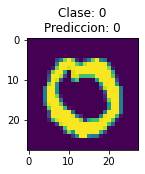

In [ ]:
import random
from matplotlib.pyplot import subplots

idx = random.randint(0, len(dataset) - 1)
T, l = dataset[idx]
pred = torch.argmax(my_nn(T)).to('cpu').numpy()
n_ejemplos = 1
fig, ax = subplots(nrows=n_ejemplos , figsize=(2,n_ejemplos*3))
img = T.view(28,28).to('cpu').numpy()
ax.set_title("Clase: "+ str(l) + "\nPrediccion: " +  str(pred))
ax.imshow(img)

## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [ ]:
from torch.utils.data import DataLoader

def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  red.to(device)
  dataloader = DataLoader(dataset, batch_size)
  all = 0
  n_batches = 0
  for x, y in dataloader:
    x = x.to(device)
    y = y.to(device)
    n_batches += 1
    pred = red(x)
    prediction = torch.argmax(pred, 1).to(device)
    correct = (prediction == y).sum() * 1.0
    total = batch_size * 1.0
    this_accuracy = correct/total
    all += this_accuracy
  
  total_accuracy = all / n_batches
  return total_accuracy

### Correccion red

In [ ]:
from torch.utils.data import Subset
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

In [ ]:
from torch.utils.data import DataLoader
your_network = my_nn

def results(red, dataset, device='cuda'):
  red.to(device)
  dataloader_test = DataLoader(test_set)
  all_predictions = torch.zeros(0)
  for x, y in dataloader_test:
    x = x.to(device)
    y = y.to(device)
    pred = red(x)
    prediction = torch.argmax(pred, 1).to(device)
    all_predictions = torch.cat((all_predictions, prediction), 0)
  return all_predictions

result = results(my_nn, test_set, device='cpu')

corrector.sumbit(homework=1, question="network", test=1, token=token, answer=result)

Correct Test!


## 3e) Opcional: Muestra los casos en donde la red se equivoca

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  if sys.path[0] == '':


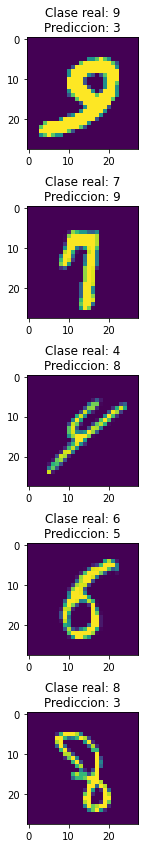

In [ ]:
def get_wrong_indexes(red, dataset, batch_size=1000, device='cuda'):
  red.to(device)
  dataloader = DataLoader(dataset, batch_size)
  batch = 0
  incorrect_indexes = torch.zeros(0).long().to(device)
  incorrect_predictions = torch.zeros(0).long().to(device)
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    pred = red(x)
    prediction = torch.argmax(pred, 1).to(device)
    incorrect = i*batch_size + (prediction != y).nonzero().flatten()
    incorrect_indexes = torch.cat((incorrect_indexes, incorrect), 0)
    batch+=1
  return incorrect_indexes

def plot_random_mistakes(red, dataset, n_samples, batch_size=1000, device='cuda'):
  indexes = get_wrong_indexes(red, dataset, batch_size, device)
  fig, axs = subplots(nrows=n_samples, figsize=(2,n_samples*3))
  for i in range(n_samples):  
    n = random.randint(0,len(indexes) - 1)
    idx = indexes[n].to(device)
    T, l = dataset[idx]
    t = T.to(device)
    prediction = torch.argmax(red(t), 1).to('cpu').numpy()
    img = T.view(28,28).numpy()
    axs[i].set_title("Clase real: "+ str(l) + "\nPrediccion: " + str(prediction[0]))
    axs[i].imshow(img)

plot_random_mistakes(my_nn, dataset, n_samples=5, batch_size=1000, device='cuda')

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [ ]:
import torchvision
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import string
import random
import os

letters = string.ascii_lowercase

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = 'black'
ctx.fillRect(0, 0, canvas.width, canvas.height)
ctx.lineWidth = %d
ctx.strokeStyle = 'white'
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/jpeg'))
  }
})
</script>
"""

def draw(label, w=280, h=280, line_width=10):
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    path_label = f"user_numbers/{label}/"
    file_name = ''.join(random.choice(letters) for i in range(10)) + ".jpg"
    os.makedirs(path_label, exist_ok=True)
    with open(path_label + file_name, 'wb') as f:
        f.write(binary)
    return binary

In [ ]:
draw(label=6) # Cambiar label dependiendo del número que se quiera dibujar

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xdb\x00C\x01\x03\x03\x03\x04\x03\x04\x08\x04\x04\x08\x10\x0b\t\x0b\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\xff\xc0\x00\x11\x08\x01\x18\x01\x18\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a

In [ ]:
user_made = torchvision.datasets.ImageFolder(
        root="user_numbers/",
        transform=torchvision.transforms.Compose([
            # transformamos las imagenes a blanco y negro
            torchvision.transforms.Grayscale(num_output_channels=1),
            # achicamos la imagen de 280x280 a 28x28 (mas facil dibujar en 280)
            torchvision.transforms.Resize((28, 28), interpolation=2),
            # a tensor de pytorch
            torchvision.transforms.ToTensor()
        ]) 
    )
# Gracias por las limitaciones pytorch...
user_made.target_transform = lambda _id: int(list(user_made.class_to_idx.keys())[list(user_made.class_to_idx.values()).index(_id)])
dataloader_user = DataLoader(user_made, batch_size=1)

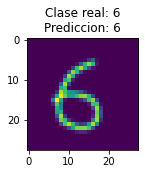

In [ ]:
def predict_my_drawings(red, dataloader, device='cuda'):
  red.to(device)
  for x, y in dataloader:
    x = x.to(device)
    pred = red(x)
    prediction = torch.argmax(pred, 1).to('cpu').numpy()
    real = y.to('cpu').numpy()
    fig, ax = subplots(nrows=1 , figsize=(2,3))
    img = x.view(28,28).to('cpu').numpy()
    ax.set_title("Clase real: "+ str(real[0]) + "\nPrediccion: " + str(prediction[0]))
    ax.imshow(img)

predict_my_drawings(my_nn, dataloader_user, 'cuda')